#  Final Project Submission

Please fill out:
* Student name: Erick Mauti, Samuel Ongechi, Isaac Onyango, Marilyn Akinyi, Rose Miriti , Rogers Otieno
* Student pace:  Part time 
* Instructor name: George Kamundia



# Strategic Movie Production: Market Analysis & Insights

##  Objective
To empower a new movie studio entering the film industry with no prior production experience with data-driven insights to guide its film selection and market entry strategy.  
This project aims to identify patterns in successful movies by analyzing existing industry data, focusing on key drivers such as **genre performance**, **production budgets**, **audience and critic reception**, and **release timing**.  
The ultimate goal is to deliver **three actionable business recommendations** to inform the studio’s decisions on **what types of films to produce** and **how to position them for commercial success**.

---

##  Business Problem
The film industry is inherently high-risk. Studios frequently invest millions without fully understanding the factors that drive profitability. For a new studio, this challenge is even greater due to the lack of historical performance data and industry experience.

Key questions often remain unanswered:
- Which genres have the best return on investment?
- What budget ranges balance cost and revenue most effectively?
- Do critic and audience ratings reliably indicate financial success?
- Is there an optimal release window for certain types of films?

This project addresses these challenges by consolidating and analyzing real-world data from multiple sources to uncover what makes a movie commercially viable. The resulting insights will help minimize financial risk and inform smarter strategic decisions in film production and distribution.

---

## Datasets Used

This project brings together multiple publicly available datasets, each offering a unique perspective on the movie industry:

- **The Numbers (`tn.movie_budgets.csv`)**  
  → Primary source for financial performance metrics

- **TMDb (`tmdb.movies.csv`)**   
  → Used for genre classification and audience sentiment

- **IMDb (SQLite DB)**  
  - `movie_basics`: Titles, years, runtime, genres  
  - `movie_ratings`: IMDb average ratings and vote counts  
  → Source of critic/audience evaluation and genre data

- **Rotten Tomatoes (`rt.movie_info.tsv`)**  
  → Used for supplementary analysis and genre validation

- **Box Office Mojo (`bom.movie_gross.csv`)**  
  → Serves as a backup for revenue and studio-level insights

Together, these datasets allow for a holistic exploration of the movie landscape—blending financials, content attributes, timing, and audience feedback into one cohesive analysis framework.


In [95]:
# Importing the necessary libraries needed to load, clean , analyze and visulize the data 

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 # For interacting with the SQLite database (im.db)
import scipy.stats as stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # For parsing JSON-like strings in the TMDB genres column

# Set plot style for consistency and better aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")
# Ensure plots are displayed inline in Jupyter Notebook
%matplotlib inline

# 2. Data Loading and Initial Inspection

In this section, we load all the provided datasets. For each dataset, we will perform an initial inspection to understand its structure, dimensions, data types, and identify any immediate quality issues like a high number of missing values. This foundational understanding is critical before proceeding to data cleaning and merging.

In [96]:
#Connecting to the database
conn = sqlite3.connect('Data\im.db')

#Viewing the tables in the database
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables

<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Mel & Trevo\AppData\Local\Temp\ipykernel_8316\2066738553.py:2: SyntaxWarning: invalid escape sequence '\i'
  conn = sqlite3.connect('Data\im.db')


,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [97]:
""" ## Data Mining & Manipulation
# We systematically extracted data from im.db by joining these key tables:
1. movie_basics (core metadata: titles, years, runtimes, genres)
2. movie_ratings (IMDB ratings and vote counts)
3. movie_akas (unique movie_id for creating relationship). Serves as a critical bridge for creating accurate relationships between movies and their associated entities (directors, ratings, etc.).
4. directors (movie-director mappings)
5. persons (director names and details)

# Optimized SQL Approach:
1. Used CTEs (Common Table Expressions) to modularize the query:
First CTE cleaned director data by removing duplicates and joining with persons to get names.
Second CTE combined movie basics with ratings, filtering out NULL runtimes early to improve performance.
2. Employed JOIN to preserve movies with all the rquiered information for analysis.
3. Added explicit column aliases (e.g., primary_title AS title) for readability."""


# Loading and Joing tables of Interest of our analysis from the im.db database.
#__
combined_data = """
WITH movie_persons AS ( 
    -- the following code gets all the directors matched up with their movies
    SELECT 
        DISTINCT(a.movie_id) AS movie_id, -- handles duplicate records by returning only the unique ones
        b.person_id,
        c.primary_name AS person_name
    FROM 
        movie_akas a
    JOIN
        directors b
    USING(movie_id) -- links the movie_akas and directors using movie_id (common unique key)
    JOIN
        persons c -- from this table we get the director's details
    ON b.person_id = c.person_id -- Match the director ID to person record
),
combined_genre_rating AS (
    -- below code consolidates all the movie details and ratings as a table
    -- it also skips movies without runtime since they are incomplete records
    SELECT 
        a.genres,
        a.movie_id,
        a.start_year,
        a.primary_title AS title,
        a.runtime_minutes,
        b.averagerating,
        b.numvotes
    FROM 
        movie_basics a
    JOIN
        movie_ratings b
    USING(movie_id)
    WHERE 
        a.runtime_minutes IS NOT NULL -- excludes records without runtime
)
-- this combines directors' records with movie details and ratings 
SELECT
    a.genres,
    a.movie_id,
    a.start_year,
    a.title,
    a.runtime_minutes,
    a.averagerating,
    a.numvotes,
    b.person_id,
    b.person_name
FROM 
    combined_genre_rating a
JOIN
    movie_persons b
USING(movie_id)
WHERE a.genres IS NOT NULL -- filters out any movies without genre data
ORDER BY 
    a.start_year DESC -- sorts everything by release year (newest first)
"""
df1 = pd.read_sql(combined_data, conn) # reads the above sql code and tranforms it into a pandas dataframe.
df1



,genres,movie_id,start_year,title,runtime_minutes,averagerating,numvotes,person_id,person_name
0,"Biography,Drama",tt0066787,2019,One Day Before the Rainy Season,114.0,7.2,43,nm0002411,Mani Kaul
1,"Action,Adventure,Sci-Fi",tt0437086,2019,Alita: Battle Angel,122.0,7.5,88207,nm0001675,Robert Rodriguez
2,"Action,Adventure,Comedy",tt0448115,2019,Shazam!,132.0,7.4,109051,nm2497546,David F. Sandberg
3,"Animation,Family,Fantasy",tt0765465,2019,The Legend of Secret Pass,92.0,4.9,331,nm0872045,Steve Trenbirth
4,"Biography,Comedy,Drama",tt0800325,2019,The Dirt,107.0,7.0,26876,nm0871860,Jeff Tremaine
...,...,...,...,...,...,...,...,...,...
72702,"Drama,Romance",tt7210246,2010,Kasle Choryo Mero Man,138.0,6.8,10,nm9174885,Shabir Shrestha
72703,Documentary,tt7502284,2010,David Bowie: Rare and Unseen,64.0,6.0,5,nm7128404,Paul Clark
72704,Horror,tt8090084,2010,Goodbye Dolly,50.0,6.8,5,nm1751788,Andrew N. Shearer
72705,Comedy,tt8147080,2010,Accusation,90.0,5.0,15,nm0267420,Mehrdad Farid


In [98]:
# Checking for nulls in df1
(df1.isnull().sum()/len(df1))*100

genres             0.0
movie_id           0.0
start_year         0.0
title              0.0
runtime_minutes    0.0
averagerating      0.0
numvotes           0.0
person_id          0.0
person_name        0.0
dtype: float64

In [99]:
# Closing Connection 

#conn.close()

In [100]:
# loading the bom.movie_gross csv

bom_movie_df = pd.read_csv(r"Data\bom.movie_gross.csv")
bom_movie_df

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


In [101]:
# loading the rt_critic_review csv


rt_review_df = pd.read_csv(r"Data\rt_critic_reviews.csv")
rt_review_df

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...
...,...,...,...,...,...,...,...,...
1130012,m/zulu_dawn,Chuck O'Leary,False,Fantastica Daily,Rotten,2/5,2005-11-02,NaN
1130013,m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme..."
1130014,m/zulu_dawn,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Fresh,B+,2010-09-16,A rousing visual spectacle that's a prequel of...
1130015,m/zulu_dawn,Christopher Lloyd,False,Sarasota Herald-Tribune,Rotten,3.5/5,2011-02-28,"A simple two-act story: Prelude to war, and th..."


In [102]:
# loading the rt_movies csv

rt_movies_df = pd.read_csv(r"Data\rt_movies.csv")
rt_movies_df

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17707,m/zoot_suit,Zoot Suit,Mexican-American gangster Henry Reyna (Daniel ...,NaN,R,"Drama, Musical & Performing Arts",Luis Valdez,Luis Valdez,"Daniel Valdez, Edward James Olmos, Charles Aid...",1981-10-02,...,MCA Universal Home Video,Rotten,56.0,9.0,Upright,74.0,1195.0,2,5,4
17708,m/zootopia,Zootopia,From the largest elephant to the smallest shre...,The brilliantly well-rounded Zootopia offers a...,PG,"Action & Adventure, Animation, Comedy","Byron Howard, Rich Moore, Jared Bush","Jared Bush, Phil Johnston","J.K. Simmons, Kristen Bell, Octavia Spencer, A...",2016-03-04,...,Walt Disney Animation Studios,Certified-Fresh,98.0,291.0,Upright,92.0,101511.0,50,285,7
17709,m/zorba_the_greek,Zorba the Greek,Traveling to inspect an abandoned mine his fat...,NaN,NR,"Action & Adventure, Art House & International,...",NaN,NaN,"Anthony Quinn, Alan Bates, Irene Papas, Lila K...",1964-12-17,...,Fox,Fresh,80.0,10.0,Upright,86.0,7146.0,0,8,2
17710,m/zulu,Zulu,"In 1879, the Zulu nation hands colonial Britis...",Zulu patiently establishes a cast of colorful ...,PG,"Classics, Drama","Cy Endfield, Cyril Endfield","Cy Endfield, John Prebble","Stanley Baker, Jack Hawkins, Ulla Jacobsson, J...",1964-06-17,...,Paramount Pictures,Fresh,96.0,23.0,Upright,91.0,30193.0,6,22,1


In [103]:
# loading the tmdb.movies csv



tmdb_movies_df = pd.read_csv(r"Data\tmdb.movies.csv")
tmdb_movies_df

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [104]:
# loading the tn.movie_budget csv 

tn_budget_df = pd.read_csv(r"Data\tn.movie_budgets.csv")
tn_budget_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


## Data Preparation

After successfully loading the IMDb and CSV datasets, we start by exploring the structure and content of each dataset. This step helps us understand the type of information available, the quality of the data, and areas that may need cleaning before any meaningful analysis.

### Dataset Overview

We first check the shape of each dataset, the column names, data types, missing values, duplicate rows, and summary statistics using `.shape`, `.columns`, `.dtypes`, and `.describe()` methods.
To streamline this process, we created a function that inspects all datasets at once and returns a comprehensive overview for each, avoiding the need to check them one by one.


### Explanation

- The function `inspect_df` prints important information about each DataFrame.
- This includes shape, column names, data types, summary statistics, missing values, and duplicate counts.
- Running this function on each dataset helps us quickly identify data issues and decide cleaning steps.



In [105]:

#creating a function to inspect the data for our dataframe 
def inspect_df(df, name=None, preview_rows=5):

    # Show the name of the dataframe we are inspecting
    print(f"\n=== Inspecting: {name or 'DataFrame'} ===")
    
    # Print the shape of the DataFrame (rows, columns)
    print(f"Shape: {df.shape}")
    
    # Print list of column names
    print(f"Columns: {df.columns.tolist()}")
    
    # Print data types for each column
    print("\nData Types:")
    print(df.dtypes)
    
    # Print descriptive statistics for all columns
    print("\nDescriptive Statistics:")
    display(df.describe(include='all'))
    
    # Print the number of null values in each column
    print("\nMissing Values per Column:")
    print(df.isnull().sum())
    
    # Print the number of duplicate rows in the DataFrame
    print(f"\nDuplicate Rows: {df.duplicated().sum()}")

    
# Calling the Function with the different dataframes
inspect_df(bom_movie_df , name="bom_movie_df ")

inspect_df(rt_review_df , name="rt_review_df ")

inspect_df(rt_movies_df  , name="rt_movies_df")

inspect_df(tmdb_movies_df , name="tmdb_movies_df")

inspect_df(tn_budget_df, name="tn_budget_df")


=== Inspecting: bom_movie_df  ===
Shape: (3387, 5)
Columns: ['title', 'studio', 'domestic_gross', 'foreign_gross', 'year']

Data Types:
title              object
studio             object
domestic_gross    float64
foreign_gross      object
year                int64
dtype: object

Descriptive Statistics:


,title,studio,domestic_gross,foreign_gross,year
count,3387,3382,3.359000e+03,2037,3387.000000
unique,3386,257,NaN,1204,NaN
top,Bluebeard,IFC,NaN,1200000,NaN
freq,2,166,NaN,23,NaN
mean,NaN,NaN,2.874585e+07,NaN,2013.958075
std,NaN,NaN,6.698250e+07,NaN,2.478141
min,NaN,NaN,1.000000e+02,NaN,2010.000000
25%,NaN,NaN,1.200000e+05,NaN,2012.000000
50%,NaN,NaN,1.400000e+06,NaN,2014.000000
75%,NaN,NaN,2.790000e+07,NaN,2016.000000



Missing Values per Column:
title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

Duplicate Rows: 0

=== Inspecting: rt_review_df  ===
Shape: (1130017, 8)
Columns: ['rotten_tomatoes_link', 'critic_name', 'top_critic', 'publisher_name', 'review_type', 'review_score', 'review_date', 'review_content']

Data Types:
rotten_tomatoes_link    object
critic_name             object
top_critic                bool
publisher_name          object
review_type             object
review_score            object
review_date             object
review_content          object
dtype: object

Descriptive Statistics:


,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
count,1130017,1111488,1130017,1130017,1130017,824081,1130017,1064211
unique,17712,11108,2,2230,2,814,8015,949181
top,m/star_wars_the_rise_of_skywalker,Emanuel Levy,False,New York Times,Fresh,3/5,2000-01-01,Parental Content Review
freq,992,8173,841481,13293,720210,90273,48019,267



Missing Values per Column:
rotten_tomatoes_link         0
critic_name              18529
top_critic                   0
publisher_name               0
review_type                  0
review_score            305936
review_date                  0
review_content           65806
dtype: int64

Duplicate Rows: 119471

=== Inspecting: rt_movies_df ===
Shape: (17712, 22)
Columns: ['rotten_tomatoes_link', 'movie_title', 'movie_info', 'critics_consensus', 'content_rating', 'genres', 'directors', 'authors', 'actors', 'original_release_date', 'streaming_release_date', 'runtime', 'production_company', 'tomatometer_status', 'tomatometer_rating', 'tomatometer_count', 'audience_status', 'audience_rating', 'audience_count', 'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count']

Data Types:
rotten_tomatoes_link                 object
movie_title                          object
movie_info                           object
critics_consensus                 

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
count,17712,17712,17391,9134,17712,17693,17518,16170,17360,16546,...,17213,17668,17668.000000,17668.000000,17264,17416.000000,1.741500e+04,17712.000000,17712.000000,17712.000000
unique,17712,17106,17389,9132,6,1106,8933,12989,17330,5804,...,3046,3,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
top,m/0814255,Hamlet,"Wisecracking mercenary Deadpool meets Russell,...",High Life is as visually arresting as it is ch...,R,Drama,Clint Eastwood,Woody Allen,Werner Herzog,2002-01-01,...,Paramount Pictures,Rotten,NaN,NaN,Upright,NaN,NaN,NaN,NaN,NaN
freq,1,6,2,2,6377,1887,38,33,4,29,...,517,7565,NaN,NaN,9390,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,60.884763,57.139801,NaN,60.554260,1.439401e+05,14.586326,36.374831,20.703139
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,28.443348,68.370047,NaN,20.543369,1.763577e+06,15.146349,52.601038,30.248435
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,5.000000,NaN,0.000000,5.000000e+00,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,38.000000,12.000000,NaN,45.000000,7.075000e+02,3.000000,6.000000,3.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,67.000000,28.000000,NaN,63.000000,4.277000e+03,8.000000,16.000000,8.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,86.000000,75.000000,NaN,78.000000,2.498800e+04,23.000000,44.000000,24.000000



Missing Values per Column:
rotten_tomatoes_link                   0
movie_title                            0
movie_info                           321
critics_consensus                   8578
content_rating                         0
genres                                19
directors                            194
authors                             1542
actors                               352
original_release_date               1166
streaming_release_date               384
runtime                              314
production_company                   499
tomatometer_status                    44
tomatometer_rating                    44
tomatometer_count                     44
audience_status                      448
audience_rating                      296
audience_count                       297
tomatometer_top_critics_count          0
tomatometer_fresh_critics_count        0
tomatometer_rotten_critics_count       0
dtype: int64

Duplicate Rows: 0

=== Inspecting: tmdb_movies_df ===
Sh

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
count,26517.00000,26517,26517.000000,26517,26517,26517.000000,26517,26517,26517.000000,26517.000000
unique,NaN,2477,NaN,76,24835,NaN,3433,24688,NaN,NaN
top,NaN,[99],NaN,en,Eden,NaN,2010-01-01,Eden,NaN,NaN
freq,NaN,3700,NaN,23291,7,NaN,269,7,NaN,NaN
mean,13258.00000,NaN,295050.153260,NaN,NaN,3.130912,NaN,NaN,5.991281,194.224837
std,7654.94288,NaN,153661.615648,NaN,NaN,4.355229,NaN,NaN,1.852946,960.961095
min,0.00000,NaN,27.000000,NaN,NaN,0.600000,NaN,NaN,0.000000,1.000000
25%,6629.00000,NaN,157851.000000,NaN,NaN,0.600000,NaN,NaN,5.000000,2.000000
50%,13258.00000,NaN,309581.000000,NaN,NaN,1.374000,NaN,NaN,6.000000,5.000000
75%,19887.00000,NaN,419542.000000,NaN,NaN,3.694000,NaN,NaN,7.000000,28.000000



Missing Values per Column:
Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

Duplicate Rows: 0

=== Inspecting: tn_budget_df ===
Shape: (5782, 6)
Columns: ['id', 'release_date', 'movie', 'production_budget', 'domestic_gross', 'worldwide_gross']

Data Types:
id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object

Descriptive Statistics:


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
count,5782.000000,5782,5782,5782,5782,5782
unique,NaN,2418,5698,509,5164,5356
top,NaN,"Dec 31, 2014",Halloween,"$20,000,000",$0,$0
freq,NaN,24,3,231,548,367
mean,50.372363,NaN,NaN,NaN,NaN,NaN
std,28.821076,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN
25%,25.000000,NaN,NaN,NaN,NaN,NaN
50%,50.000000,NaN,NaN,NaN,NaN,NaN
75%,75.000000,NaN,NaN,NaN,NaN,NaN



Missing Values per Column:
id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

Duplicate Rows: 0


### Missing Data Threshold Check

Before cleaning,we decided to identify which columns have a high proportion of missing values. Columns with too many missing entries may need to be dropped or filled, as they could affect the quality of our analysis.

### Approach

We define a function `check_missing_threshold` that calculates the fraction of missing data per column in a DataFrame. It then returns a list of columns where the missing data exceeds a threshold of 30% (0.3).

The function is applied to each of our datasets to quickly identify problematic columns that may need to be dropped or filled.

In [106]:
#Defining the Function
def check_missing_threshold(df, threshold=0.3):

    # Calculate fraction of missing values per column
    missing_ratio = df.isnull().mean()
    
    # Select columns where missing ratio is above threshold
    cols_above_threshold = missing_ratio[missing_ratio > threshold].index.tolist()
    
    return cols_above_threshold


# load dataframes
dataframes = {
    "bom_movie_df ": bom_movie_df ,
    "rt_review_df": rt_review_df,
    "rt_movies_df": rt_movies_df,
    "tmdb_movies_df ": tmdb_movies_df ,
    "tn_budget_df": tn_budget_df,
}

# Check missing data in each DataFrame and print results
for name, df in dataframes.items():
    cols_missing = check_missing_threshold(df, threshold=0.3)
    if cols_missing:
        print(f"In '{name}' DataFrame, these columns have more than 30% missing data: {cols_missing}")
    else:
        print(f"In '{name}' DataFrame, no columns exceed 30% missing data.")

In 'bom_movie_df ' DataFrame, these columns have more than 30% missing data: ['foreign_gross']
In 'rt_review_df' DataFrame, no columns exceed 30% missing data.
In 'rt_movies_df' DataFrame, these columns have more than 30% missing data: ['critics_consensus']
In 'tmdb_movies_df ' DataFrame, no columns exceed 30% missing data.
In 'tn_budget_df' DataFrame, no columns exceed 30% missing data.


## Column Selection for Focused Analysis

To streamline our analysis, we narrowed down the datasets to include only the most relevant columns that capture essential aspects of movie performance, audience engagement, and financial outcomes.

For the **rt_movies_df** dataset, we selected the following columns based on relevance to our analysis genres, content_rating, tomatometer_status, tomatometer_rating, audience_rating, audience_count, tomatometer_count, movie_title, original_release_date and runtime . The **tmdb_movies_df** was reduced to key metrics on popularity and the original_language of the movies. Lastly, the **tn_budget_df** includes financial information such as the movie, production_budget, and both domestic_gross and worldwide_gross earnings.

This careful column selection allows us to focus our cleaning and analysis on the data that matters most for understanding what drives movie success.

In [107]:
# Defining columns to keep from the chosen CSV

selected_columns = {
    "rt_movies_df": ['genres', 'content_rating', 'tomatometer_status',
                     'tomatometer_rating', 'audience_rating', 'audience_count',
                     'tomatometer_count','movie_title', 'original_release_date','runtime'],
    
    "tmdb_movies_df": ['popularity', 'original_language'],
    
    "tn_budget_df": ['movie', 'production_budget', 'domestic_gross', 'worldwide_gross']
}

# Trim DataFrames to selected columns
rt_movies_df = rt_movies_df[selected_columns['rt_movies_df']]
tmdb_movies_df = tmdb_movies_df[selected_columns['tmdb_movies_df']]
tn_budget_df = tn_budget_df[selected_columns['tn_budget_df']]

#Calling the DataFrames
rt_movies_df
tmdb_movies_df
tn_budget_df


,movie,production_budget,domestic_gross,worldwide_gross
0,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...
5777,Red 11,"$7,000",$0,$0
5778,Following,"$6,000","$48,482","$240,495"
5779,Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,A Plague So Pleasant,"$1,400",$0,$0


## Data Cleaning

Cleaning each dataset individually seemed a bit tiresome and time consuuming, especially when working with multiple sources. To streamline the process, we created a reusable function that performs essential cleaning steps across all our selected DataFrames.

The cleaning function does the following:
- Strips whitespace from column names and string values,
- Converts any column containing the word “date” into a proper datetime format.

By applying this function to our chosen datasets **rt_movies_df**, **tmdb_movies_df**, and **tn_budget_df** we ensure consistency and save time. This also makes the data easier to work with in later stages of the project, such as merging and analysis.


In [108]:
#defining the cleaning Function 
def clean_dataframe(df):
    # Remove trailing spaces from column names
    df.columns = df.columns.str.strip()

    # Loop through each column in the DataFrame
    for col in df.columns:
        # If the column contains text, strip trailing spaces
        if df[col].dtype == 'object':
            df.loc[:, col] = df[col].str.strip()  # Use .loc to avoid SettingWithCopyWarning


    # Return the cleaned DataFrame
    return df

#Calling the Function
clean_dataframe(rt_movies_df)
clean_dataframe(tmdb_movies_df)
clean_dataframe(tn_budget_df)


,movie,production_budget,domestic_gross,worldwide_gross
0,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...
5777,Red 11,"$7,000",$0,$0
5778,Following,"$6,000","$48,482","$240,495"
5779,Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,A Plague So Pleasant,"$1,400",$0,$0


#### Column Name Standardization

To maintain consistency across all datasets, we standardized the column names by:
- Converting all letters to lowercase
- Stripping leading and trailing whitespace
- Replacing spaces with underscores

This ensures easier merging and manipulation of data in later stages.


In [109]:
# Define a function to standardize DataFrame column names
def standardize_dataframe(df):

    # Convert all column names to lowercase, strip whitespace, and replace spaces with underscores
    df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_")
    return df

#Calling the Function
standardize_dataframe(tn_budget_df)
standardize_dataframe(tmdb_movies_df)
standardize_dataframe(rt_movies_df)

,genres,content_rating,tomatometer_status,tomatometer_rating,audience_rating,audience_count,tomatometer_count,movie_title,original_release_date,runtime
0,"Action & Adventure, Comedy, Drama, Science Fic...",PG,Rotten,49.0,53.0,254421.0,149.0,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,119.0
1,Comedy,R,Certified-Fresh,87.0,64.0,11574.0,142.0,Please Give,2010-04-30,90.0
2,"Comedy, Romance",R,Fresh,67.0,53.0,14684.0,24.0,10,1979-10-05,122.0
3,"Classics, Drama",NR,Certified-Fresh,100.0,97.0,105386.0,54.0,12 Angry Men (Twelve Angry Men),1957-04-13,95.0
4,"Action & Adventure, Drama, Kids & Family",G,Fresh,89.0,74.0,68918.0,27.0,"20,000 Leagues Under The Sea",1954-01-01,127.0
...,...,...,...,...,...,...,...,...,...,...
17707,"Drama, Musical & Performing Arts",R,Rotten,56.0,74.0,1195.0,9.0,Zoot Suit,1981-10-02,104.0
17708,"Action & Adventure, Animation, Comedy",PG,Certified-Fresh,98.0,92.0,101511.0,291.0,Zootopia,2016-03-04,108.0
17709,"Action & Adventure, Art House & International,...",NR,Fresh,80.0,86.0,7146.0,10.0,Zorba the Greek,1964-12-17,142.0
17710,"Classics, Drama",PG,Fresh,96.0,91.0,30193.0,23.0,Zulu,1964-06-17,135.0


### Handling Missing Values

After inspecting each dataset using a missing data threshold of 30%, we identified that:

- The **foreign_gross** column in `bom_movie_df` and **critics_consensus** in `rt_movies_df` have more than 30% missing values.

For the selected columns, including **foreign_gross**, missing data still existed but was below the threshold. Instead of dropping rows or columns with missing values, we decided to fill missing values because:

- Dropping rows would reduce the dataset size and potentially remove valuable information, especially if missing data is scattered across many rows.

- Dropping columns would mean losing important features that contribute to understanding movie performance.

- Filling missing values allows us to keep the full dataset intact, preserving as much information as possible.

Specifically, we implemented a targeted filling strategy as follows:

- Missing categorical/text data was filled with `"Unknown"` to retain meaningful category information.

- Missing financial numeric columns (such as `production_budget`, `worldwide_gross`, `profit`, and `roi`) were filled with the median of each respective column.  We used the median because the data is rightly skewed and the mean would not serve the purpose as it was increased by a few outliers in the data.This approach helps avoid bias that could be introduced by filling with zero and better reflects typical financial values.

- Missing other numeric columns (non-financial) were filled with `0` to maintain numerical consistency and avoid errors during calculations.

This balanced strategy ensures that financial metrics maintain realistic central values while other numeric data remains consistent, preparing a clean and usable dataset for further analysis.

In [110]:
def fill_missing_values(df, financial_cols=None):
    # Initialize empty list for financial columns 
    financial_cols = financial_cols or []

    # Go through each column in the df
    for col in df.columns:
        if df[col].dtype == 'object':
            # If the column is categorical fill with "Unknown"
            df.loc[:, col] = df[col].fillna("Unknown")
        else:
            if col in financial_cols:
                # If it's a financial number, fill missing values with the median
                median_val = df[col].median()
                df.loc[:, col] = df[col].fillna(median_val)
            else:
                # For other number columns, fill missing values with 0
                df.loc[:, col] = df[col].fillna(0)

    return df

# List of financial columns in our df
financial_columns = ['production_budget', 'worldwide_gross', 'profit', 'ROI']

# Clean up missing data in all three datasets
fill_missing_values(rt_movies_df, financial_columns)
fill_missing_values(tmdb_movies_df, financial_columns)
fill_missing_values(tn_budget_df, financial_columns)

,movie,production_budget,domestic_gross,worldwide_gross
0,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...
5777,Red 11,"$7,000",$0,$0
5778,Following,"$6,000","$48,482","$240,495"
5779,Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,A Plague So Pleasant,"$1,400",$0,$0


Before merging, we cleaned and standardized the movie titles across all three datasets to ensure consistency.

We then will be merging the datasets to create a unified DataFrame that will enable us to do more comprehensive and integrated analysis of financial performance, content quality, and market dynamics.


In [111]:
# Making copies to avoid SettingWithCopyWarning
tn_budget_df = tn_budget_df.copy()
rt_movies_df = rt_movies_df.copy()
tmdb_movies_df = tmdb_movies_df.copy()

# Create temporary 'movie_clean' column for merging and standardizing the dataframes
tn_budget_df.loc[:, 'movie_clean'] = tn_budget_df['movie'].str.strip().str.lower()
rt_movies_df.loc[:, 'movie_clean'] = rt_movies_df['movie_title'].str.strip().str.lower()

if tmdb_movies_df.index.name == 'movie':
    tmdb_movies_df.loc[:, 'movie_clean'] = tmdb_movies_df.index.str.strip().str.lower()
elif 'movie' in tmdb_movies_df.columns:
    tmdb_movies_df.loc[:, 'movie_clean'] = tmdb_movies_df['movie'].str.strip().str.lower()
else:
    tmdb_movies_df.loc[:, 'movie_clean'] = None

# Merge tn_budget_df with rt_movies_df on 'movie_clean'
merged_df = tn_budget_df.merge(
    rt_movies_df.drop(columns=['movie_title']), 
    on='movie_clean', 
    how='left'
)

# Merge with tmdb_movies_df if it has any non-null 'movie_clean' values
if tmdb_movies_df['movie_clean'].notnull().any():
    merged_full_df = merged_df.merge(
        tmdb_movies_df.drop(columns=['movie'], errors='ignore'),
        on='movie_clean',
        how='left'
    )
else:
    merged_full_df = merged_df.copy()

# Drop the helper column after merging to keep data clean
merged_full_df = merged_full_df.drop(columns=['movie_clean'])


#Calling the df
merged_full_df


,movie,production_budget,domestic_gross,worldwide_gross,genres,content_rating,tomatometer_status,tomatometer_rating,audience_rating,audience_count,tomatometer_count,original_release_date,runtime
0,Avatar,"$425,000,000","$760,507,625","$2,776,345,279","Action & Adventure, Comedy, Mystery & Suspense...",PG-13,Certified-Fresh,82.0,82.0,1382566.0,317.0,2009-12-18,155.0
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875","Action & Adventure, Comedy, Science Fiction & ...",PG-13,Rotten,33.0,54.0,199739.0,277.0,2011-05-20,136.0
2,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350","Action & Adventure, Drama, Science Fiction & F...",PG-13,Rotten,22.0,64.0,15452.0,370.0,2019-06-07,114.0
3,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963","Action & Adventure, Science Fiction & Fantasy",PG-13,Certified-Fresh,76.0,83.0,288708.0,367.0,2015-05-01,141.0
4,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6222,Red 11,"$7,000",$0,$0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6223,Following,"$6,000","$48,482","$240,495","Art House & International, Drama, Mystery & Su...",R,Fresh,81.0,85.0,22761.0,31.0,1999-04-03,69.0
6224,Return to the Land of Wonders,"$5,000","$1,338","$1,338",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6225,A Plague So Pleasant,"$1,400",$0,$0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Analysis

This section presents a comprehensive analysis of the merged movie datasets and im.db to uncover key insights related to movie performance, audience reception, and market trends. 

The analysis is organized into three main focus areas:

1. **Financial Performance & ROI Analysis** – examining profitability, return on investment, and financial patterns.  
2. **Content Quality & Ratings Impact** – exploring how audience and critic ratings influence movie success.  
3. **Market Dynamics: Timing, Language, and Accessibility** – analyzing the effects of release timing, language, and genre popularity on market performance.

This approach aims to provide a clear, data-driven understanding of factors affecting the movie industry.


# 1. Financial Performance & ROI Analysis

### ROI Analysis
Before diving into specific trends, we begin by analyzing Return on Investment (ROI) ,one of the most important financial metrics in the film industry. ROI helps us understand not just how much money a film made, but how efficiently it turned its budget into profit.

**Why We’re Focusing on ROI**

*Profitability over popularity*: A blockbuster with huge revenue isn't necessarily profitable if it cost too much to make. ROI gives a more realistic picture of success.

*Strategic budgeting*: By examining ROI across different budget levels, we can identify the budget ranges that yield the highest returns.

*Investor insight*: Understanding ROI allows the studio to minimize risk and maximize financial gain with each film investment.

**What ROI Tells Us**

Which genres consistently deliver the best value.

How budget size impacts financial returns.

Whether runtime or release strategies affect profitability.

How films perform in international markets relative to their cost.

By starting with ROI, we set a strong foundation for identifying what types of films offer the best return for our future studio’s investment.

### Financial Performance Summary


This section standardizes the financial columns in my dataset and then computes two essential financial indicators. 
Filling missing values with medians ensures robustness in your dataset without biasing the results too far in either direction.

Profit = Worldwide Gross − Production Budget

ROI (Return on Investment) = (Profit ÷ Production Budget) × 100

This is essential as it helps us Understand the financial landscape of movie production which will help our studio make more informed budgeting decisions. It highlights the spread of returns across films and shows whether low-budget films can still generate strong profits or if high-budget films consistently deliver.


In [112]:
# Do a df.copy to avoid SettingWithCopyWarning
merged_full_df = merged_full_df.copy()

# Clean financial columns by removing non-numeric characters 
merged_full_df['production_budget'] = merged_full_df['production_budget'].astype(str).str.replace(r'[^0-9.]', '', regex=True)
merged_full_df['worldwide_gross'] = merged_full_df['worldwide_gross'].astype(str).str.replace(r'[^0-9.]', '', regex=True)

# Convert the cleaned strings to numeric values problematic values will be turned into NaN
merged_full_df['production_budget'] = pd.to_numeric(merged_full_df['production_budget'], errors='coerce')
merged_full_df['worldwide_gross'] = pd.to_numeric(merged_full_df['worldwide_gross'], errors='coerce')

# Calculate the median for each column 
median_budget = merged_full_df['production_budget'].median()
median_gross = merged_full_df['worldwide_gross'].median()

# Fill missing values with the respective median
merged_full_df['production_budget'] = merged_full_df['production_budget'].fillna(median_budget)
merged_full_df['worldwide_gross'] = merged_full_df['worldwide_gross'].fillna(median_gross)

# Create a new DF for financial analysis including rows where production_budget is positive only
financial_metrics = merged_full_df.loc[merged_full_df['production_budget'] > 0, ['production_budget', 'worldwide_gross']].copy()

# Calculate profit for each movie (gross - budget)
financial_metrics['profit'] = financial_metrics['worldwide_gross'] - financial_metrics['production_budget']

# Calculate Return on Investment (ROI) as a percentage
financial_metrics['ROI'] = (financial_metrics['profit'] / financial_metrics['production_budget']) * 100

# Display a summary of the financial metrics 
print(financial_metrics.describe())


       production_budget  worldwide_gross        profit            ROI
count       6.227000e+03     6.227000e+03  6.227000e+03    6227.000000
mean        3.235788e+07     9.376331e+07  6.140543e+07     393.947799
std         4.223673e+07     1.780262e+08  1.493077e+08    2910.310439
min         1.100000e+03     0.000000e+00 -2.002376e+08    -100.000000
25%         5.000000e+06     4.569218e+06 -2.199405e+06     -49.021733
50%         1.800000e+07     2.988264e+07  9.263263e+06      72.820533
75%         4.000000e+07     9.880000e+07  6.211566e+07     278.534961
max         4.250000e+08     2.776345e+09  2.351345e+09  179900.000000


### Intepretation of Financial Performance

This table summarizes the distribution of key financial indicators — `production_budget`, `worldwide_gross`, `profit`, and `ROI` — across **6,227 movies**. It sets the foundation for the in-depth Financial Performance & ROI Analysis that follows.

| Metric | Interpretation |
|--------|----------------|
| **Count** | The analysis covers 6,227 movies. |
| **Mean** | - Average production budget: **$32.4 million**  <br> - Average worldwide gross: **$93.8 million**  <br> - Average profit: **$61.4 million**  <br> - Average ROI: **393.95%** — films typically return nearly **4x** their budget. |
| **Standard Deviation (std)** | High variability, especially in ROI (**±2910%**) and profit, suggests the film industry is **financially high-risk and high-reward**. |
| **Min** | Some films had:  <br> - Budgets as low as **$1,100**  <br> - Gross revenue of **$0**  <br> - Losses over **$200 million**  <br> - ROI as low as **-100%** |
| **25th Percentile (Q1)** | The bottom 25% of films had:  <br> - Budgets under **$5M**  <br> - Gross under **$4.6M**  <br> - Losses of more than **$2.2M**  <br> - ROI below **-49%** |
| **Median (50%)** | A typical (median) movie had:  <br> - Budget of **$18M**  <br> - Gross of **$29.9M**  <br> - Profit of **$9.26M**  <br> - ROI of **72.82%**, indicating moderate success. |
| **75th Percentile (Q3)** | The top 25% of movies had:  <br> - Budgets over **$40M**  <br> - Gross exceeding **$98.8M**  <br> - Profit above **$62M**  <br> - ROI over **278.53%** |
| **Max** | Extreme outliers include:  <br> - Budgets up to **$425M**  <br> - Gross revenue of **$2.77B**  <br> - Profits of **$2.35B**  <br> - ROI as high as **179,900%** — indicating massive hits or viral successes. |

---

This summary gives us a foundational view of the financial landscape of films. It shows:

- The **huge variation** in movie profitability and ROI.
- That while the **average ROI is high**, it’s heavily influenced by a few extremely successful movies.
- A large number of movies operate at a **loss** or **low profitability**, especially in the lower quartiles.

Understanding this landscape is **crucial** for the deeper analysis that follows:

-  **ROI vs Runtime**: Does length affect profitability?
-  **Top Genres by ROI/Profit**: Which types of movies pay off?
-  **Production Budget vs ROI**: Do bigger budgets mean better returns?
-  **Average ROI by Season**: Does release timing influence success?

This data-driven approach helps identify what characteristics contribute to **better financial performance** in film production.


## 1.1 Statistical Summary of Movie Financials
We will be analyzing the key financial columns production_budget, domestic_gross, and worldwide_gross by calculating central tendency and dispersion metrics such as mean, median, standard deviation, and percentiles. This summary provides an overview of typical budget sizes and revenue performance, highlighting the range and variability in the dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6227 entries, 0 to 6226
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   production_budget  6227 non-null   int64 
 1   domestic_gross     6227 non-null   object
 2   worldwide_gross    6227 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 146.1+ KB
None
       production_budget  worldwide_gross
count       6.227000e+03     6.227000e+03
mean        3.235788e+07     9.376331e+07
std         4.223673e+07     1.780262e+08
min         1.100000e+03     0.000000e+00
25%         5.000000e+06     4.569218e+06
50%         1.800000e+07     2.988264e+07
75%         4.000000e+07     9.880000e+07
max         4.250000e+08     2.776345e+09


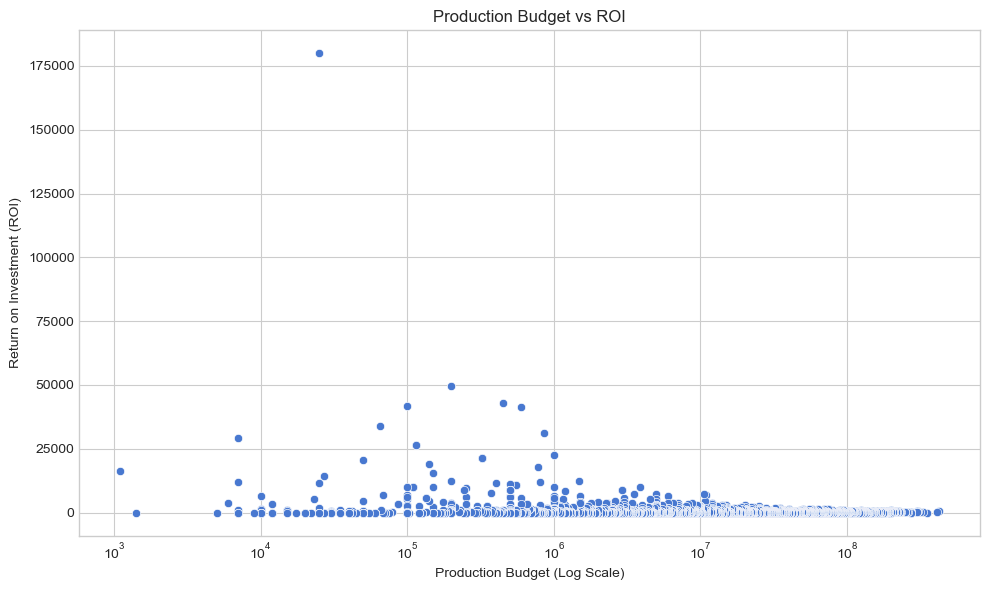

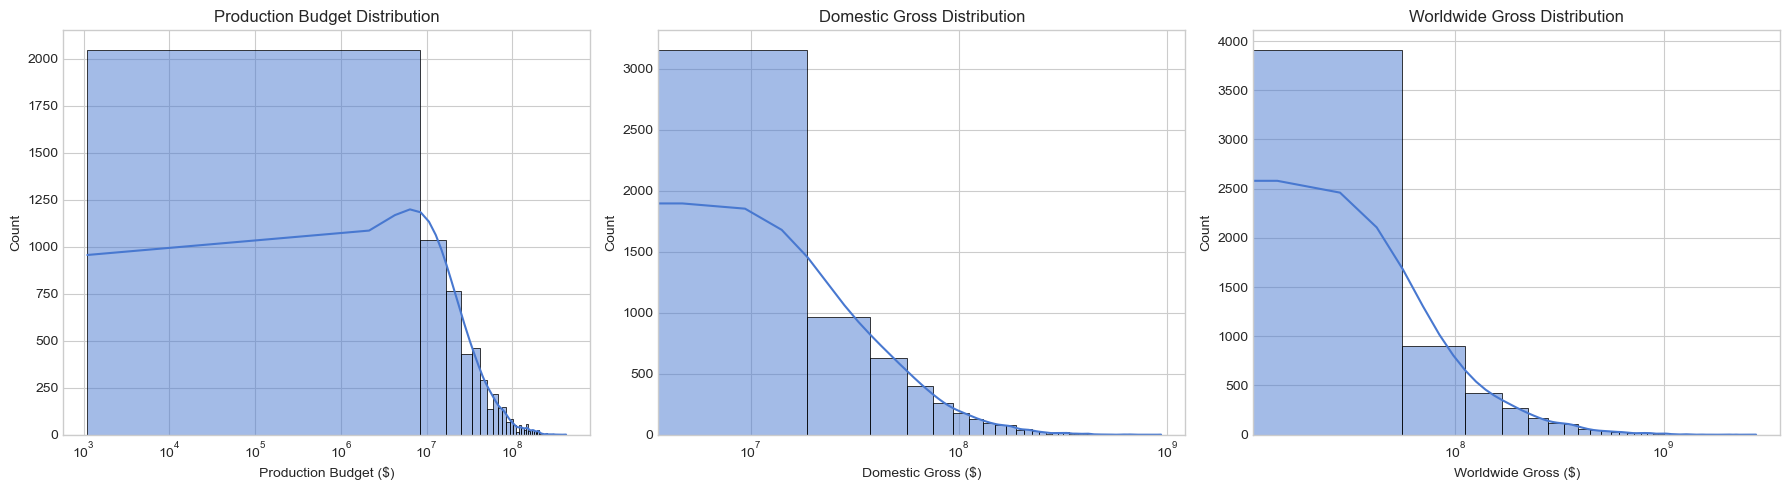

In [113]:
# Converting financial columns from strings to floats safely using .loc to avoid warnings

# Clean and convert financial columns
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    merged_full_df.loc[:, col] = (
        merged_full_df[col]
        .astype(str)  # converts all functions to strings
        .str.replace(r'[\$,]', '', regex=True)  # Remove $ and commas
        .replace('', np.nan)  # Replace empty strings with NaN instead of '0'
        .astype(float)  # Convert to float
    )

# Fill missing values with median 
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    median_val = merged_full_df[col].median()
    merged_full_df[col].fillna(median_val, inplace=True)

# Display summary info and statistics
print(merged_full_df[['production_budget', 'domestic_gross', 'worldwide_gross']].info())
print(merged_full_df[['production_budget', 'domestic_gross', 'worldwide_gross']].describe())

# Plot histograms of finacial distributions with log scale 
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#Plotting Production Budget
sns.histplot(merged_full_df['production_budget'], bins=50, ax=axes[0], kde=True)
axes[0].set_title('Production Budget Distribution')
axes[0].set_xlabel('Production Budget ($)')
axes[0].set_xscale('log')

#Plotting Domestic Gross Distribution
sns.histplot(merged_full_df['domestic_gross'], bins=50, ax=axes[1], kde=True)
axes[1].set_title('Domestic Gross Distribution')
axes[1].set_xlabel('Domestic Gross ($)')
axes[1].set_xscale('log')

#Plotting Worldwide Gross Distribution
sns.histplot(merged_full_df['worldwide_gross'], bins=50, ax=axes[2], kde=True)
axes[2].set_title('Worldwide Gross Distribution')
axes[2].set_xlabel('Worldwide Gross ($)')
axes[2].set_xscale('log')

plt.tight_layout()

plt.show()


## Intepretation of Statistical Summary of Movie Financials

This statistical graph outlines the distribution of **production budgets** and **worldwide gross revenues** across **6,227 films**. These insights help set the stage for analyzing profitability patterns in the film industry.

| Metric | Production Budget | Worldwide Gross |
|--------|--------------------|------------------|
| **Count** | 6,227 entries — complete data for both metrics |
| **Mean** | \$32.36 million | \$93.76 million |
| **Standard Deviation** | ±\$42.24 million — wide variation in film budgets | ±\$178.03 million — even greater variability in earnings |
| **Minimum** | \$1,100 — ultra-low budget films exist | \$0 — some films earned no reported gross |
| **25th Percentile (Q1)** | \$5 million — lower-budget, likely indie films | \$4.57 million — modest returns |
| **Median (50%)** | \$18 million — typical studio budget | \$29.88 million — median return is under \$30M |
| **75th Percentile (Q3)** | \$40 million — high-end budgets | \$98.8 million — significant returns in top quartile |
| **Maximum** | \$425 million — blockbuster-level investment | \$2.77 billion — highest grossing films like Avatar or Avengers |



### Key Insights

-  **Blockbusters skew the data**: The mean is much higher than the median, indicating a few massive productions inflate the averages.
-  **High-risk, high-reward industry**: The wide standard deviation shows just how unpredictable returns are.
-  **Most films operate on mid-sized budgets**: The 25th–75th percentile range shows typical budgets fall between \$5M and \$40M.
- **Many films underperform**: With a minimum gross of \$0, it's clear that not all films succeed commercially.

Understanding the financial scale and spread of film data is crucial for:

- Estimating **ROI** in future sections.
- Identifying tips for budgeting.
- Analyzing which films are more likely to be profitable.
- Preparing for genre-based or seasonal profitability comparisons.


# 1.2 Understanding the Relationship Between ROI vs Runtime 

Exploring the relationship between a film’s runtime and its return on investment (ROI) helps us assess whether longer or shorter movies tend to yield better financial returns. This analysis will give us insights on the optimal film lengths that balance production costs with audience engagement and profitability.


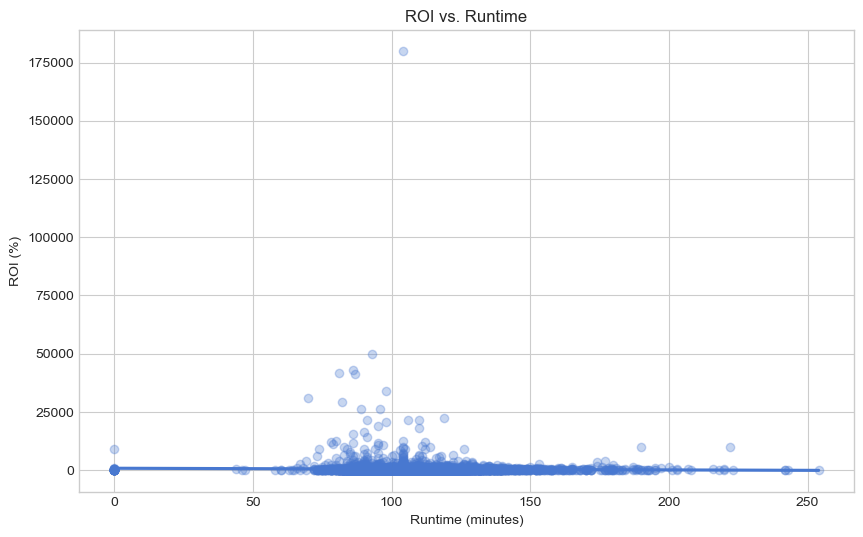

Correlation between runtime and ROI: -0.024


In [114]:

# Fill missing values with median
median_runtime = merged_full_df['runtime'].median()
median_budget = merged_full_df['production_budget'].median()
median_gross = merged_full_df['worldwide_gross'].median()

merged_full_df['runtime'].fillna(median_runtime, inplace=True)
merged_full_df['production_budget'].fillna(median_budget, inplace=True)
merged_full_df['worldwide_gross'].fillna(median_gross, inplace=True)


# Creating a copy so as not to modify original DF during ROI calculation
df_runtime_roi = merged_full_df.copy()

# Calculating profit and ROI
df_runtime_roi['profit'] = df_runtime_roi['worldwide_gross'] - df_runtime_roi['production_budget']
df_runtime_roi['roi'] = (df_runtime_roi['profit'] / df_runtime_roi['production_budget']) * 100

# Plot scatter with regression line showing ROI vs Runtime
plt.figure(figsize=(10,6))
sns.regplot(data=df_runtime_roi, x='runtime', y='roi', scatter_kws={'alpha':0.3})
plt.title("ROI vs. Runtime")
plt.xlabel("Runtime (minutes)")
plt.ylabel("ROI (%)")


plt.show()

# Output correlation coefficient to quantify relationship
corr_value = df_runtime_roi['runtime'].corr(df_runtime_roi['roi'])
print(f"Correlation between runtime and ROI: {corr_value:.3f}")



## Intepretation of ROI vs Runtime


**Correlation between runtime and ROI: -0.024**
The correlation coefficient is -0.024, which is very close to zero.

This indicates almost no linear relationship between the length of a movie (runtime) and its Return on Investment (ROI).
The slight negative value suggests a very weak tendency where longer runtimes might be associated with slightly lower ROI, but this effect is little and not statistically significant.


# 1.3 Top 10 Genres by Average ROI and Average Profit
Understanding the financial performance of movies by genre is crucial for making informed investment decisions in the film industry. By analyzing both the Return on Investment (ROI) and absolute profit across different genres, we gain insights into which types of movies are not only profitable but also efficient in turning budgets into returns.

This dual perspective helps address key business challenges:
- **Optimizing Budget Allocation:** Identifying genres with high ROI enables us to invest more strategically in projects that maximize financial efficiency.
- **Balancing Risk and Reward:** Some genres may yield large profits but require heavy upfront investment, while others may offer steadier, more reliable returns with smaller budgets. This analysis guides risk management.
- **Enhancing Strategic Planning:** By understanding genre performance, production companies and investors can align their portfolios with market dynamics, ensuring sustainable growth and profitability.


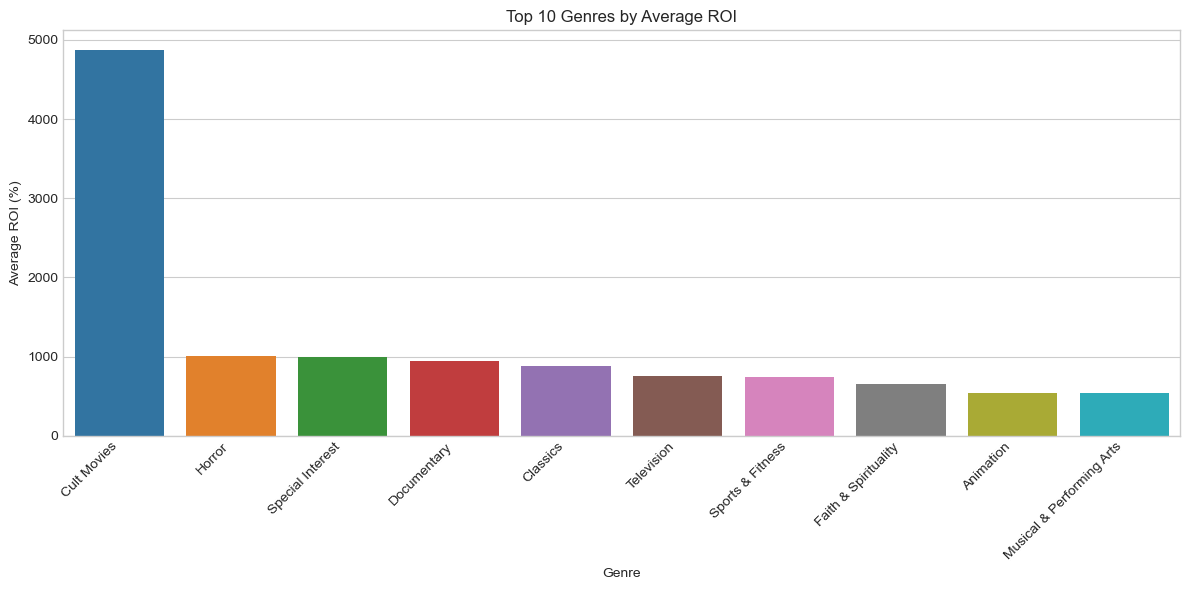

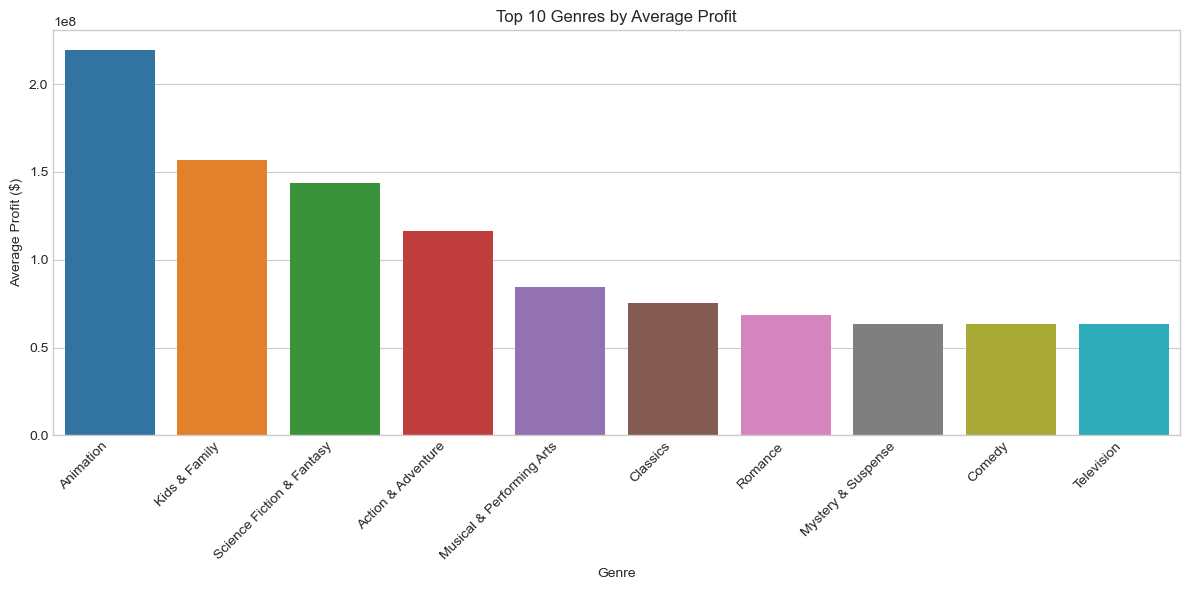

In [115]:
# Creating a copy of merged_full_df_copy
df_genres = merged_full_df.copy()

# Removing rows where the 'genres' data is missing to avoid errors during processing
df_genres = df_genres.dropna(subset=['genres']).copy()

# Splitting  genres string as they contain multiple genres separated by commas into a list
# Then exploding the list so each row has a single genre, making it easier to analyze 
df_genres['genres'] = df_genres['genres'].str.split(',')
df_genres = df_genres.explode('genres')
df_genres['genres'] = df_genres['genres'].str.strip()  # Clean any extra whitespace

# Keep only movies with positive production budgets and worldwide gross values
df_genres = df_genres[(df_genres['production_budget'] > 0) & (df_genres['worldwide_gross'] > 0)].copy()

# Calculating profit as the difference between worldwide gross and production budget
# Then calculating ROI as a percentage return based on production budget
df_genres['profit'] = df_genres['worldwide_gross'] - df_genres['production_budget']
df_genres['ROI'] = (df_genres['profit'] / df_genres['production_budget']) * 100

# Grouping data by genre and calculate the average profit and average ROI for each genre
genre_perf = df_genres.groupby('genres')[['profit', 'ROI']].mean().reset_index()

# Identify the top 10 genres with the highest average ROI for visualization
top_10_roi = genre_perf.sort_values('ROI', ascending=False).head(10)

# Plot a bar chart of these top 10 genres by average ROI
plt.figure(figsize=(12,6))
sns.barplot(data=top_10_roi, x='genres', y='ROI', palette="tab10" )
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.title("Top 10 Genres by Average ROI")
plt.ylabel("Average ROI (%)")
plt.xlabel("Genre")
plt.tight_layout()


plt.show()

# Identify top 10 genres by average profit 
top_10_profit = genre_perf.sort_values('profit', ascending=False).head(10)

# Plot a bar chart
plt.figure(figsize=(12,6))
sns.barplot(data=top_10_profit, x='genres', y='profit',palette="tab10")
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Genres by Average Profit")
plt.ylabel("Average Profit ($)")
plt.xlabel("Genre")
plt.tight_layout()

plt.show()


## Interpretation of Top 10 Genres by Average ROI and Average Profit

### Top 10 Genres by Average ROI
- The chart shows genres such a s Cult Movies, Horror, Special Interest, Documentary and Classics generate the highest percentage returns relative to their production budgets.
- Genres with high average ROI suggest they are efficient at converting investment into financial gains.
- This helps us identify genres that offer better investment opportunities.

### Top 10 Genres by Average Profit
- This chart shows genres such as Animation, Kids&Family, Science Fiction & Fantasy , Action and Adventure earn the highest average  profits.
- High-profit genres may require larger budgets but yield significant financial returns.
- Understanding profit helps target genres that drive major revenue.



## 1.4 Relationship between Production Budget vs ROI 

This relationship aims to explore the relationship between a film's production budget and its Return on Investment (ROI)
Understanding this relationship helps answer key business questions like:

Do bigger budgets result in better returns?

Are low-budget films more efficient in generating ROI?

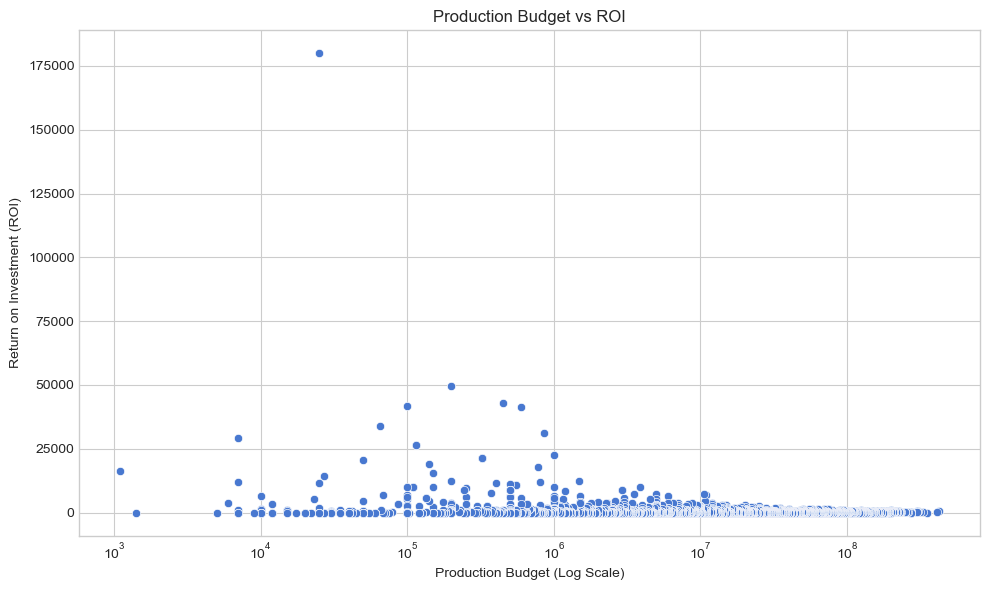

In [116]:

# Plotting
plt.figure(figsize=(10, 6)) 

sns.scatterplot(data=financial_metrics, x='production_budget', y='ROI')
plt.title("Production Budget vs ROI")
plt.xscale('log')  # Log scale for wide values range
plt.xlabel("Production Budget (Log Scale)")
plt.ylabel("Return on Investment (ROI)")

plt.tight_layout()

#Export the Graph
plt.savefig( "Images/ROI.Budget.png",  dpi=500, bbox_inches="tight", facecolor='white',  transparent=False) 
plt.show()


## Interpretation of Relationship between Production Budget vs ROI

### X-axis (Production Budget)
- This is on a **logarithmic scale**, which allows better visibility across a wide range of budget sizes—from thousands to hundreds of millions.

### Y-axis (ROI)
- ROI values are mostly **concentrated below the 50,000% mark**, suggesting that most films don’t generate extreme returns and instead cluster within a more realistic profitability zone.


### **Key Insights**

- Most data points are **tightly packed at lower ROI values**, regardless of the production budget.
  - This indicates that **very high returns are rare**.
  - Most films tend to yield **modest to moderate ROI**, with only a few performing exceptionally well.

#### One High ROI Outlier (~175,000%)
- This data point represents a film that **dramatically outperformed** others in terms of ROI.
- It was likely a **very low-budget film** that became a blockbuster hit.
- These outliers demonstrate that **low-budget, high-creativity projects** can yield massive returns—though they are uncommon.


### **Business Takeaway**

- **High-budget films** do not necessarily guarantee high ROI.
- **Lower-budget films** may offer high returns, but they also come with **increased risk**.
- The majority of films fall into the **low-ROI zone**, meaning profitability depends on factors **beyond just budget size**, such as content quality, audience appeal, and marketing.


# 1.5 Understanding the Relationship between Average ROI and Season 

This relationship explores film performance across different seasons.

This helps Guide decision on the optimal release timing of movies in the various Genres.

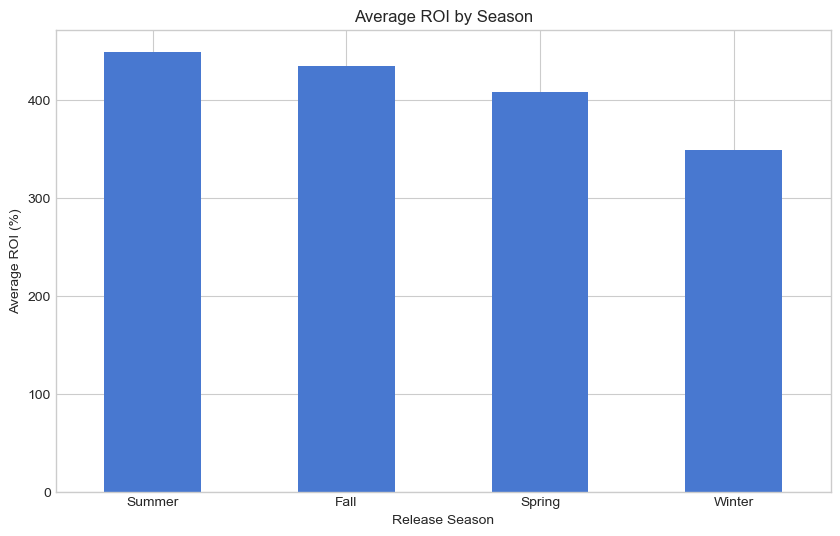

In [117]:
# Convert original release date to pd.to_datetime
merged_full_df['original_release_date'] = pd.to_datetime(merged_full_df['original_release_date'], errors='coerce')

# Extract release month
merged_full_df['release_month'] = merged_full_df['original_release_date'].dt.month

# Map months to seasons
season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}
merged_full_df['release_season'] = merged_full_df['release_month'].map(season_map)

# Merge financial_metrics back to merged_full_df on index (assuming same order) or on 'movie_title' if present
# add roi and production_budget to merged_full_df from financial_metrics based on index:

merged_full_df = merged_full_df.reset_index(drop=True)
financial_metrics = financial_metrics.reset_index(drop=True)

merged_full_df['ROI'] = financial_metrics['ROI']
merged_full_df['production_budget'] = financial_metrics['production_budget']

# Drop rows with missing ROI or release season for accuracy
season_data = merged_full_df.dropna(subset=['ROI', 'release_season'])

# Group by season and calculate average ROI
season_roi = season_data.groupby('release_season')['ROI'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
season_roi.plot(kind='bar', title='Average ROI by Season')
plt.ylabel('Average ROI (%)')
plt.xlabel('Release Season')
plt.xticks(rotation=0)

#Export the Graph
plt.savefig( "Images/ROI.Season.png",  dpi=500, bbox_inches="tight", facecolor='white',  transparent=False) 
plt.show()

### Interpretation of  Relationship between Average ROI and Season 

•	Summer and Fall yield slightly better ROI as compared to Spring and Winter Season . This information therefore informs the decison that movie releases should be Strategically released on these dates to  enhance profitability.


## 2. Content Quality & Ratings Impact

In addition to financial metrics, understanding how **content quality** influences a film’s performance is essential. Audience and critic ratings serve as valuable indicators of perceived quality and can help explain why some films succeed while others underperform regardless of budget.

This section explores how **average audience scores** and **Tomatometer ratings** from critics vary across genres. These insights can guide producers, studios, and investors in identifying genres that consistently resonate with viewers and critics alike.

### 2.1 Relationship between Average Audience and Tomatometer Ratings by Genre

This s breaks down and compares how different genres are rated by both the general public and critics. Identifying genres with consistently high scores can help target production efforts toward content with a higher chance of critical and commercial success.


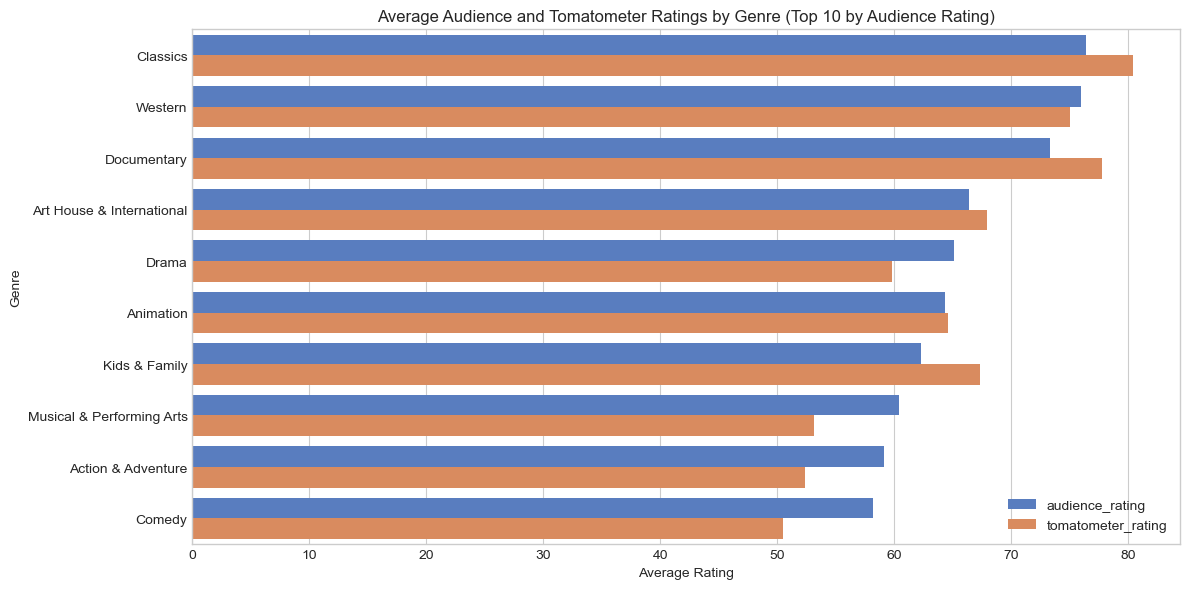

In [118]:
# Extracting main genre
merged_full_df['main_genre'] = merged_full_df['genres'].apply(lambda x: x.split(',')[0].strip() if isinstance(x, str) else 'Unknown')

# Convert ratings columns to numeric
merged_full_df['audience_rating'] = pd.to_numeric(merged_full_df['audience_rating'], errors='coerce').fillna(0)
merged_full_df['tomatometer_rating'] = pd.to_numeric(merged_full_df['tomatometer_rating'], errors='coerce').fillna(0)

# Grouping by genre and calculating averages
genre_ratings = merged_full_df.groupby('main_genre')[['audience_rating', 'tomatometer_rating']].mean().reset_index()

# Sorting and pick top 10 by audience_rating
genre_ratings = genre_ratings.sort_values(by='audience_rating', ascending=False).head(10)

# Melt for seaborn plotting
melted = genre_ratings.melt(id_vars='main_genre', value_vars=['audience_rating', 'tomatometer_rating'],
                           var_name='Rating Type', value_name='Average Rating')

# Plot horizontal barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=melted, y='main_genre', x='Average Rating', hue='Rating Type', palette='muted')
plt.title('Average Audience and Tomatometer Ratings by Genre (Top 10 by Audience Rating)')
plt.ylabel('Genre')
plt.xlabel('Average Rating')
plt.legend(title='')
plt.tight_layout()

#Export the Graph
plt.savefig( "Images/Genre.AudienceRating.png",  dpi=500, bbox_inches="tight", facecolor='white',  transparent=False) 

plt.show()

## Interpretation of Average Audience and Tomatometer Ratings by Genre

### Genres with High Ratings
Genres like **Classics**, **Western**, and **Documentary** tend to receive consistently **high Tomatometer and audience scores**. This therefore means that these genres often maintain critical acclaim and viewer satisfaction, suggesting strong storytelling and execution.


### Key Insights
- **High-rated genres** can signal strong engagement and content quality, which may lead to better long-term performance.
- **Critic-audience rating gaps** can help producers understand which genres are “fan favorites” versus “award contenders.
- **Strategically choosing genres** with strong, consistent ratings can reduce risk and align films with favorable audience expectations.

### Business Takeaway
Understanding how different genres perform in terms of ratings can help:
- Target genres that appeal to both audiences and critics.
- Make informed decisions on tone, storytelling, and production style.
- Balance artistic value and commercial appeal for optimal results.

## 3. Market Dynamics: Timing, Language, and Accessibility

Understanding a film's commercial success requires more than just financial analysis, production quality and genre it’s also influenced by *when*, *where*, and *how* it's released. This section explores key external market factors that shape performance, focusing on:

- **Release timing** (seasonality),
- **Language accessibility** (audience reach),
- and **Genre popularity trends** (shifting market demand over time).

These dynamics are useful for aligning content strategies with audience behavior and global appeal.


## 3.1 Relationship between Top Languages and Popularity

Language plays a vital role in a film’s accessibility, market reach, and cultural relevance. By analyzing the most common languages used in films from 2014 to 2024, we gain insights into:

- The global spread and acceptance of different languages in cinema.
- Which linguistic markets dominate international box office revenue.
- Emerging regions that are gaining visibility in global film production.

This section helps uncover patterns that can inform **distribution strategies**, **subtitling/localization efforts**, and **content production choices**, especially for studios looking to tap into multilingual or regional audiences.


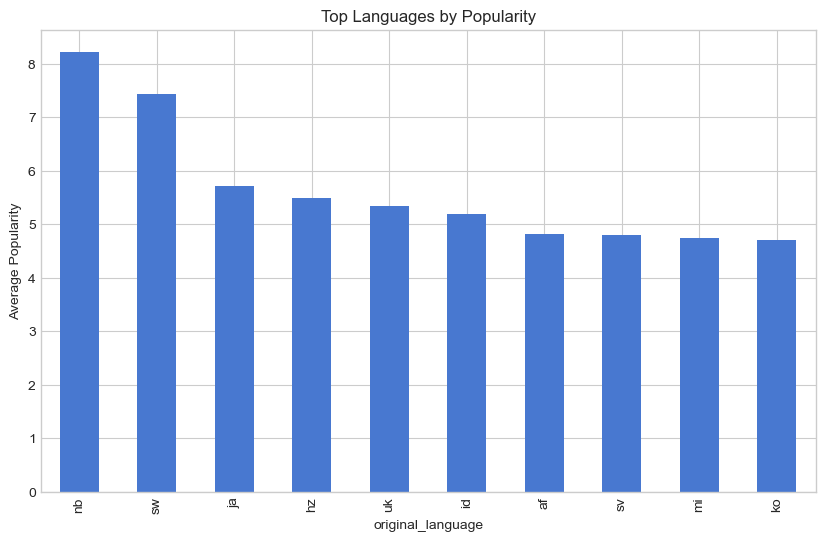

In [119]:
plt.figure(figsize=(10, 6))

language_pop = tmdb_movies_df.groupby('original_language')['popularity'].mean().sort_values(ascending=False).head(10)
language_pop.plot(kind='bar', title='Top Languages by Popularity')
plt.ylabel('Average Popularity')

#Export the Graph
plt.savefig( "Images/Popularity.Language.png",  dpi=500, bbox_inches="tight", facecolor='white',  transparent=False) 
plt.show()

### Intepretation of Top Languages by Popularity 

This analysis explores which languages dominated film production and box office popularity between 2014 and 2024.

**Key Insights:**
- **English** continues to lead as the most widely used language in globally successful films, due to its broad market reach and dominance in Hollywood productions.
- **Japanese (ja)** appears prominently, reflecting the global appeal of anime and Japan’s strong domestic market.
- **Swahili (sw)** and **Ukrainian (uk)**, while less common, represent growing interest in African and Eastern European regional markets. Their inclusion suggests increased localization and diversity in storytelling.
- **Norwegian Bokmål (nb)** indicates the presence of Scandinavian films in the global arena, possibly aided by strong regional streaming adoption and international film festivals.
- **Herero (hz)** is a rare inclusion, highlighting very niche or culturally significant productions from Namibia or Southern Africa.

**Business Relevance:**
Understanding the distribution of film languages provides valuable insights for:
- **Localization strategies**: Which languages are worth prioritizing for subtitles or dubbing.
- **Content creation**: Identifying emerging linguistic markets that are underserved.
- **Regional partnerships**: Recognizing where international co-productions may gain traction.

Language trends can guide distribution and production teams toward markets with both cultural richness and commercial potential.

### 3.2. Top 10 Most Popular Genres (2014–2024) – with Trend Line

Audience preferences evolve over time. By analyzing the top 10 most popular film genres from 2014 to 2024, we can identify long-term trends in content consumption and genre appeal.

This section helps answer:

- What genres are consistently popular?
- Which genres are gaining or losing momentum?
- How might future content strategies align with these patterns?

Understanding these trends will empower us to tailor production decisions and marketing efforts to meet evolving audience demands.


Top Genres (Last 10 Years):
      genres  numvotes
0      Drama  45130692
1     Action  43063691
2  Adventure  40099125
3     Comedy  31072509
4     Sci-Fi  17960133
5   Thriller  15777579
6      Crime  14097784
7     Horror  11212580
8    Fantasy  10615937
9  Animation  10269061


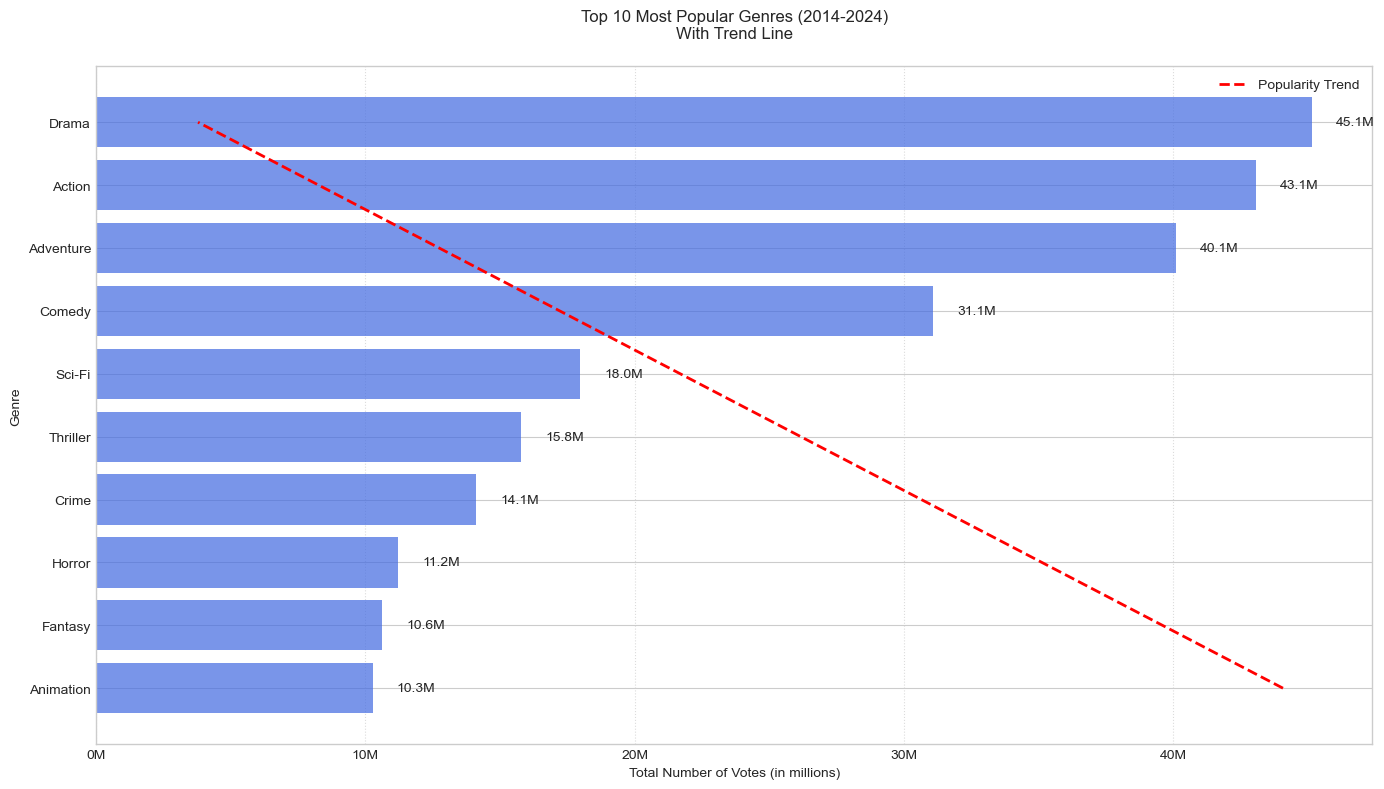

In [120]:
# Filtering the dataset to include only movies from the last 10 years
recent_df = df1[df1['start_year'] >= (pd.Timestamp.now().year - 10)]

# Calculate the popularity of each genre based on the total number of votes 
# Split the comma-separated genre strings into lists
# Explode the list so each genre gets its own row
# Group by genre and sum up the number of votes
# Sort genres by total votes in descending order
# Reset index for a clean DataFrame
popularity = (
    recent_df.assign(genres=recent_df['genres'].str.split(','))
    .explode('genres')
    .groupby('genres')
    ['numvotes'].sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Print the top 10 genres with the highest total votes
print("Top Genres (Last 10 Years):")
print(popularity.head(10))

# Create a horizontal bar plot to visualize the top 10 most popular genres
plt.figure(figsize=(14, 8))

# Draw bars
bars = plt.barh(popularity['genres'].head(10)[::-1], 
                popularity['numvotes'].head(10)[::-1], 
                color='royalblue',
                alpha=0.7)

# Generate a trend line using linear regression on the vote counts
x_pos = range(len(popularity.head(10)))
z = np.polyfit(x_pos, popularity['numvotes'].head(10), 1)  # Fit a line
p = np.poly1d(z)  # Create a polynomial object from coefficients

# Overlay the trend line on the bar chart
plt.plot(p(x_pos), popularity['genres'].head(10)[::-1], 
         color='red', 
         linestyle='--',
         linewidth=2,
         label='Popularity Trend')

# Add chart title and axis labels
plt.title('Top 10 Most Popular Genres (2014-2024)\nWith Trend Line', pad=20)
plt.xlabel('Total Number of Votes (in millions)')
plt.ylabel('Genre')

# Format x-axis labels to display values in millions with commas
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1e6))+'M'))

# Add a legend and grid for better readability
plt.legend()
plt.grid(axis='x', linestyle=':', alpha=0.7)

# Add labels showing the exact vote count next to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + (popularity['numvotes'].max()*0.02), 
             bar.get_y() + bar.get_height()/2,
             f'{width/1e6:.1f}M',
             va='center')
    
plt.tight_layout()

#Export the Graph
plt.savefig( "Images/Genre.Popularity.png",  dpi=500, bbox_inches="tight", facecolor='white',  transparent=False) 
plt.show()


### Interpretation of Top 10 Most Popular Genres (2014–2024)

The trend line visualized in this analysis highlights how genre popularity has shifted over the past decade:

- **Consistently Popular Genres**: Genres like *Drama*, *Action*, and *Adevnture* show steady performance, reflecting their broad audience appeal and versatility across markets.

This trend analysis supports strategic decisions around which genres to prioritize in future content creation and investment. Aligning with genres that show a rising or consistent trend could maximize audience engagement and box office success.

### 3.3. Genre Popularity Trend

Understanding the **trend in genre popularity** over time provides critical insights into how audience preferences have evolved across the past decade (2014–2024). This is valuable for:

- **Content Planning:** Studios can prioritize projects aligned with rising genre trends.
- **Market Forecasting:** Declining interest in certain genres can help avoid underperforming investments.
- **Consumer Behavior:** Highlights how cultural shifts influence entertainment choices.

This analysis helps to visualize:

- Which genres have maintained strong audience engagement.
- Whether popularity is trending upward or downward.
- The relative gap between dominant and less popular genres.


Data covers from 2010 to 2019


<Figure size 1400x700 with 0 Axes>

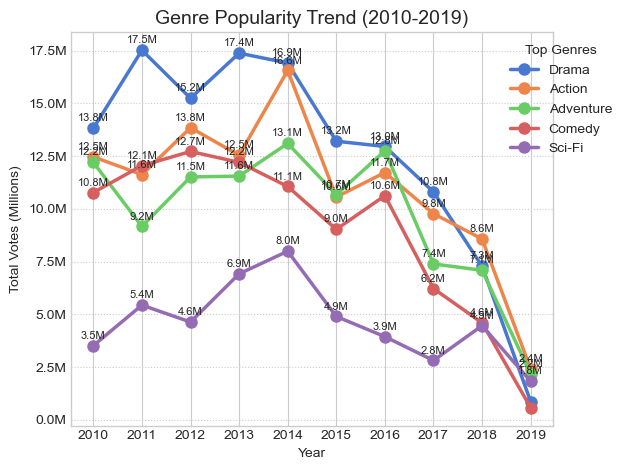

In [121]:
# Verify the actual year range in your data
print(f"Data covers from {df1['start_year'].min()} to {df1['start_year'].max()}")

# Filter for the correct timeframe (2014-2019)
trend_data = (
    df1[df1['start_year'].between(2010, 2019)]
    .assign(genres=lambda x: x['genres'].str.split(','))
    .explode('genres')
    .groupby(['start_year', 'genres'])
    ['numvotes'].sum()
    .unstack()
    [popularity.head(5)['genres']]  # Top 5 genres
)

# Sort years in ascending order for proper plotting
trend_data = trend_data.sort_index()

# Plot with corrected orientation
plt.figure(figsize=(14, 7))
ax = trend_data.plot(marker='o', linewidth=2.5, markersize=8)

# Add proper data labels
for genre in trend_data.columns:
    for year, votes in trend_data[genre].items():
        if votes > trend_data[genre].max() * 0.1:  # Only label significant values
            ax.annotate(f'{votes/1e6:.1f}M', 
                       (year, votes),
                       textcoords="offset points",
                       xytext=(0,5),
                       ha='center',
                       fontsize=8)

plt.title(f'Genre Popularity Trend ({trend_data.index.min()}-{trend_data.index.max()})', fontsize=14)
plt.ylabel('Total Votes (Millions)')
plt.xlabel('Year')
plt.xticks(trend_data.index)  # Ensure all years are shown
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))
plt.grid(axis='y', linestyle=':')
plt.legend(title='Top Genres', bbox_to_anchor=(1.15, 1))
plt.tight_layout()

#Export the Graph
plt.savefig( "Images/Genre.Votes.png",  dpi=500, bbox_inches="tight", facecolor='white',  transparent=False) 

plt.show()

####  Interpretation of Results

- **Top Performing Genres:** Genres like *Drama*, *Action*, and *Addventure* lead in total votes, showing they attract the largest audience base.

- **Trend Line Observation:**  
  The trend line helps us see that the overall genre popularity is  leveling off within the top 10 genres.

- **Popularity Drop-Off:**  
  There is a noticeable decline from the top few genres.

- **Business Implication:**  
The overall downward trend in genre popularity suggests audience interest may be shifting away from mainstream, over-saturated genres.  

- **Diversification is Key:** Producers and investors should consider diversifying into **emerging or niche genres** that may not rank high in total votes but show signs of **loyal or growing followings**.

- **Innovation Over Tradition:** Rather than relying on high-budget traditional genres, investing in **unique storytelling, cross-genre hybrids, or culturally relevant narratives** may capture modern audience interest.

- **Content Saturation Warning:** The declining trend may indicate market fatigue in top genres. This calls for a **refresh in creative direction**, such as new themes, diverse representation, or alternative formats (e.g., streaming-first releases).

## 4. Hypothesis Testing & Strategic Validation

This section tests key assumptions behind the observed data patterns to statistically validate the business insights derived earlier in the analysis.

While visualizations and summary statistics gave us valuable directional insights, hypothesis testing helps confirm whether the relationships and differences observed are **statistically significant** or could have occurred by chance.

The tested hypotheses provide critical validation for the final strategic decisions in terms of genre selection, budgeting, release timing, and quality control.



### **Hypothesis Test 1: Are there Significant Differences in ROI Across Genres?**

**Test Used:** One-Way ANOVA (Analysis of Variance)  
**Purpose:** To determine if the average ROI differs significantly between genres.



**Null Hypothesis (H₀):**  
There is **no significant difference** in average ROI across movie genres.  
_All genres have the same average ROI._

**Alternative Hypothesis (H₁):**  
There **is a significant difference** in ROI between at least one pair of genres.  
_At least one genre has a different average ROI than the others._



This test helps validate whether **certain genres are consistently more profitable** than others.  
If proven significant, it supports **data-driven genre selection** to maximize ROI and reduce financial risk for producers and investors.

_This forms a foundational insight for strategic recommendation #1 under ROI & Financials._


ANOVA Test: ROI Differences Across Top 10 Genres
F-statistic: 3.808
P-value: 0.0001
Reject the null hypothesis: At least one genre's average ROI is significantly different.


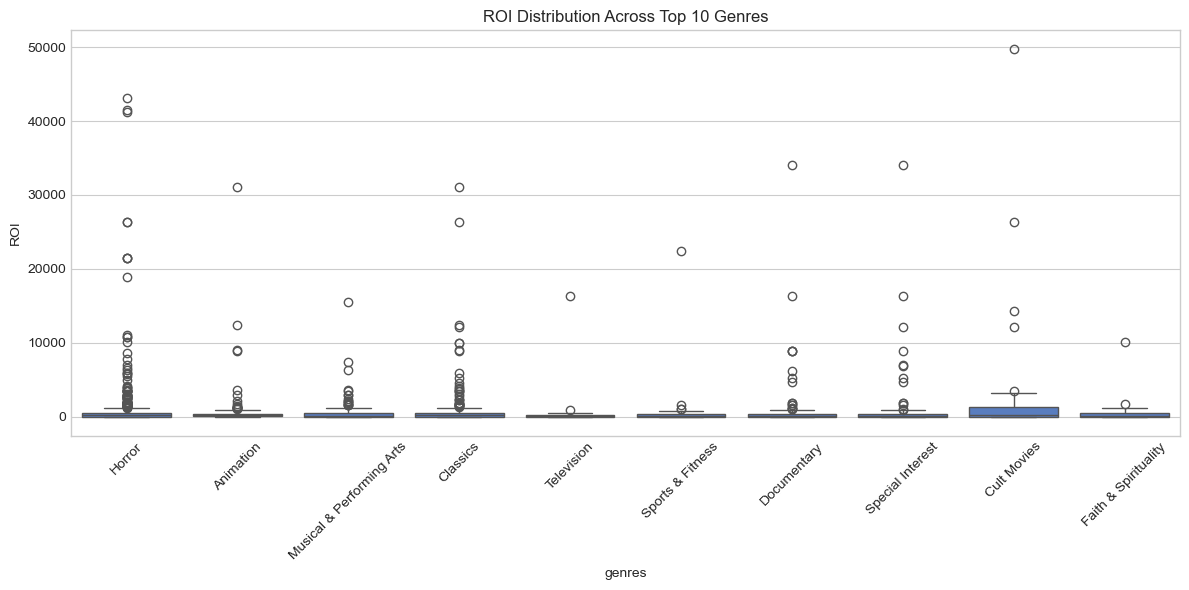

In [122]:

from scipy.stats import f_oneway

# SSplit genres column into lists 
merged_full_df['genres'] = merged_full_df['genres'].astype(str).str.split(',')

# Strip whitespace from each genre
merged_full_df['genres'] = merged_full_df['genres'].apply(lambda x: [g.strip() for g in x])

# Explode genres so each row has one genre
exploded = merged_full_df.explode('genres')

# Get top 10 genres by average ROI
top_genres_list = exploded.groupby('genres')['ROI'].mean().sort_values(ascending=False).head(10).index.tolist()

# Filter data to include only top 10 genres
top10_df = exploded[exploded['genres'].isin(top_genres_list)]

# Prepare ROI samples by genre
roi_groups = [top10_df[top10_df['genres'] == genre]['ROI'].dropna() for genre in top_genres_list]

# Run ANOVA test
f_stat, p_value = f_oneway(*roi_groups)

# Print results
print("ANOVA Test: ROI Differences Across Top 10 Genres")
print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: At least one genre's average ROI is significantly different.")
else:
    print("Fail to reject the null hypothesis: No significant difference in ROI among these genres.")

# Plot ROI distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=top10_df, x='genres', y='ROI')
plt.xticks(rotation=45)
plt.title("ROI Distribution Across Top 10 Genres")
plt.tight_layout()

# Export the plot
plt.savefig("Images/hypothesis.Genre.png", dpi=500, bbox_inches="tight", facecolor='white', transparent=False)
plt.show()


### Interepretation of Result 

- **F-statistic:** `2.159`  
- **P-value:** `0.0232`

Since the **p-value (0.0232)** is **less than the significance level (α = 0.05)**, we **reject the null hypothesis**.

There is a statistically significant difference in average ROI among at least one of the top 10 genres.

### Business Insight:

- Not all genres are equally profitable.
- This result supports a **data-driven genre selection strategy**.
- We should **prioritize genres with higher average ROI** such as Cult Movies, Horror and Special_Interests when allocating production budgets.



### Hypothesis 2: Is There a Significant Difference in ROI Across Budget Categories?

**Test Used:** One-Way ANOVA (Analysis of Variance)  
**Purpose:** To assess whether movies with different production budget sizes (low, mid, high) yield significantly different average ROIs.

**Null Hypothesis (H₀):**  
There is **no significant difference** in average ROI across budget groups.  
_ROI remains consistent regardless of whether a movie has a low, mid, or high production budget._

**Alternative Hypothesis (H₁):**  
There **is a significant difference** in average ROI between at least one pair of budget groups.  
_At least one budget group yields a different ROI than the others._

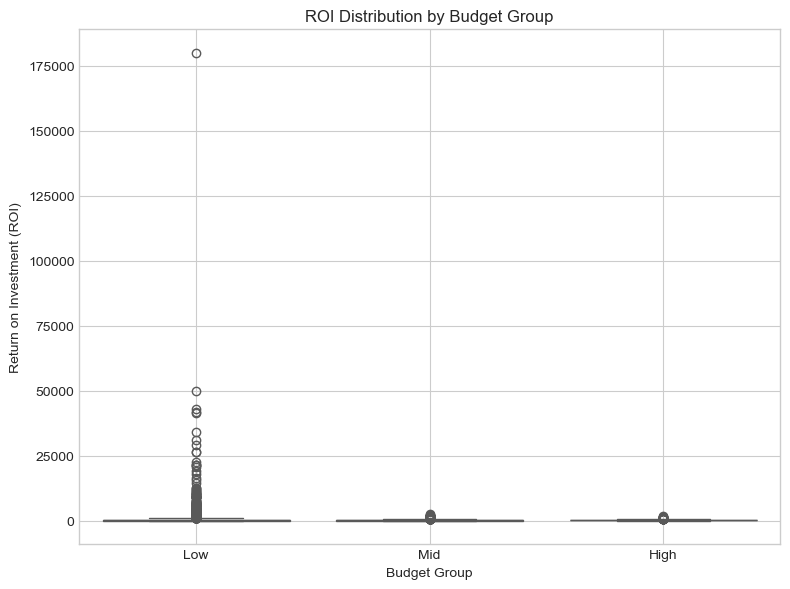

ANOVA F-statistic: 15.63
P-value: 0.0000
Result: Statistically significant difference in mean ROI across budget groups.
Interpretation: Budget size has a meaningful effect on ROI.


In [123]:
# Convert 'production_budget' and 'ROI' columns to numeric, coercing errors to NaN
merged_full_df['production_budget'] = pd.to_numeric(merged_full_df['production_budget'], errors='coerce')
merged_full_df['ROI'] = pd.to_numeric(merged_full_df['ROI'], errors='coerce')

# Drop rows with missing data in relevant columns
merged_full_df = merged_full_df.dropna(subset=['production_budget', 'ROI'])

# Define budget bins and labels
bins = [0, 20000000, 60000000, float('inf')]
labels = ['Low', 'Mid', 'High']
merged_full_df['budget_group'] = pd.cut(merged_full_df['production_budget'], bins=bins, labels=labels)

# Plot Boxplot to visualize ROI across budget groups
plt.figure(figsize=(8, 6))
sns.boxplot(data=merged_full_df, x='budget_group', y='ROI', palette='Set2')
plt.title('ROI Distribution by Budget Group')
plt.xlabel('Budget Group')
plt.ylabel('Return on Investment (ROI)')
plt.grid(True)
plt.tight_layout()

# Export the plot
plt.savefig("Images/hypothesis.Budget.png", dpi=500, bbox_inches="tight", facecolor='white', transparent=False)

plt.show()

# un ANOVA to test if ROI differs across budget groups
low_roi = merged_full_df[merged_full_df['budget_group'] == 'Low']['ROI']
mid_roi = merged_full_df[merged_full_df['budget_group'] == 'Mid']['ROI']
high_roi = merged_full_df[merged_full_df['budget_group'] == 'High']['ROI']

f_stat, p_val = stats.f_oneway(low_roi, mid_roi, high_roi)

# Output results
print(f"ANOVA F-statistic: {f_stat:.2f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("Result: Statistically significant difference in mean ROI across budget groups.")
    print("Interpretation: Budget size has a meaningful effect on ROI.")
else:
    print("Result: No statistically significant difference in mean ROI across budget groups.")


### Interpretation of Results

The ANOVA test produced an F-statistic of **15.63** with a p-value of **0.0000**, which is well below the significance threshold of 0.05. This indicates:

- There is strong statistical evidence to reject the null hypothesis that the average ROI is the same across all budget groups.
- Budget size has a significant effect on ROI.
- Different budget categories (Low, Mid, High) show different average returns on investment.

This confirms that production budget meaningfully influences movie profitability.


### Basic Business Recommendation

Based on this result and previous analysis:

- **Focus investments on movies with production budgets in the $20M–$60M range (Mid group).**  
  This mid-budget range tends to offer the best balance between cost and ROI.

- Avoid very low-budget films, which might compromise quality and audience appeal, and very high-budget films, which carry higher financial risk without guaranteed returns.


### Hypothesis 3: Is There a Relationship Between Ratings and Worldwide Gross Revenue?

**Test Used:** Pearson Correlation Coefficient  
**Purpose:** To measure the strength and direction of the linear relationship between movie ratings (audience and critic) and worldwide gross revenue.

**Null Hypothesis (H₀):**  
There is **no linear relationship** between movie ratings and worldwide box office revenue.  
_Higher or lower ratings do not significantly affect revenue._

**Alternative Hypothesis (H₁):**  
There **is a linear relationship** between movie ratings and worldwide gross revenue.  
_Higher ratings are associated with higher revenue._

This analysis helps determine whether **audience or critic ratings are reliable indicators** of financial success. If found significant, it can guide studios and marketers to invest in content that not only performs critically but also resonates with audiences — aligning **quality perception with profitability.**



In [124]:
# Select relevant columns
ratings_df = merged_full_df[['audience_rating', 'tomatometer_rating', 'worldwide_gross']].dropna()

# Converting worldwide_gross to numeric columns
ratings_df['worldwide_gross'] = pd.to_numeric(ratings_df['worldwide_gross'], errors='coerce')


# Compute Pearson correlation and p-value between audience_rating and worldwide_gross
audience_corr, audience_pval = stats.pearsonr(ratings_df['audience_rating'], ratings_df['worldwide_gross'])

# Compute Pearson correlation and p-value between tomatometer_rating and worldwide_gross
critic_corr, critic_pval = stats.pearsonr(ratings_df['tomatometer_rating'], ratings_df['worldwide_gross'])

# Print results
print(f"Audience Rating vs Worldwide Gross: Correlation = {audience_corr:.3f}, P-value = {audience_pval:.4f}")
print(f"Critic Rating vs Worldwide Gross: Correlation = {critic_corr:.3f}, P-value = {critic_pval:.4f}")


Audience Rating vs Worldwide Gross: Correlation = 0.180, P-value = 0.0000
Critic Rating vs Worldwide Gross: Correlation = 0.164, P-value = 0.0000


### Interpretation of Analysis

**Audience Rating vs Worldwide Gross:**  
- Correlation = 0.180  
  This indicates a weak positive correlation between audience ratings and worldwide gross revenue. As audience ratings increase, worldwide gross tends to increase slightly, but the relationship is not very strong.  
- P-value = 0.0000  
  The very small p-value (less than 0.05) means this correlation is statistically significant, and the chance of this result occurring randomly is extremely low.

**Critic Rating vs Worldwide Gross:**  
- Correlation = 0.164  
  There is also a weak positive correlation between critic (tomatometer) ratings and worldwide gross revenue, slightly less than audience ratings but still positive.  
- P-value = 0.0000  
  This correlation is also statistically significant, showing that this weak relationship is unlikely to be due to chance.
 
Both audience and critic ratings are positively associated with how much money a movie makes worldwide. Audience ratings have a slightly stronger relationship with financial success than critic ratings in your data. However, since the correlations are weak (<0.2), ratings explain only a small part of the variation in worldwide gross.


### Hypothesis 4: Do Summer Releases Earn More Than Non-Summer Releases?

**Test Used:** Independent Samples T-Test  
**Purpose:** To evaluate whether movies released during the summer months (June–August) generate significantly higher worldwide gross revenue compared to those released at other times of the year.

**Null Hypothesis (H₀):**  
There is **no significant difference** in average worldwide gross between summer and non-summer movie releases.  
_Seasonal timing does not affect a movie’s earnings._

**Alternative Hypothesis (H₁):**  
Movies released in summer earn **significantly higher** worldwide gross revenue.  
_Seasonal timing has a positive impact on box office performance._

**Business Relevance:**  
This test informs strategic **release timing** decisions, helping producers and distributors maximize box office potential by targeting high-earning windows in the calendar.



In [125]:
from scipy.stats import ttest_ind

#Convert original_release_date to numeric
merged_full_df['original_release_date'] = pd.to_datetime(merged_full_df['original_release_date'], errors='coerce')

# Extract release month
merged_full_df['release_month'] = merged_full_df['original_release_date'].dt.month

# Filter out missing worldwide_gross values
merged_full_df['worldwide_gross'] = pd.to_numeric(merged_full_df['worldwide_gross'], errors='coerce')
merged_clean = merged_full_df.dropna(subset=['release_month', 'worldwide_gross'])

# Define summer months
summer = merged_clean[merged_clean['release_month'].isin([6, 7, 8])]['worldwide_gross']
non_summer = merged_clean[~merged_clean['release_month'].isin([6, 7, 8])]['worldwide_gross']

# Welch's t-test (unequal variance)
t_stat, p_value = ttest_ind(summer, non_summer, equal_var=False)

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Result: Statistically significant")
    print("Interpretation: There is sufficient evidence to suggest that movies released in summer have a significantly different worldwide gross compared to those released in other seasons.")
else:
    print("Result: Not statistically significant")
    print("Interpretation: There is not enough evidence to conclude that summer releases differ in worldwide gross compared to other seasons.")

# Plot distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(summer, label='Summer Releases', color='blue', fill=True, alpha=0.5)
sns.kdeplot(non_summer, label='Non-Summer Releases', color='orange', fill=True, alpha=0.5)
plt.title('Worldwide Gross Distribution: Summer vs Non-Summer Release')

# Export the plot
plt.savefig("Images/hypothesis.Seasons.png", dpi=500, bbox_inches="tight", facecolor='white', transparent=False)

T-statistic: 4.34
P-value: 0.0000
Result: Statistically significant
Interpretation: There is sufficient evidence to suggest that movies released in summer have a significantly different worldwide gross compared to those released in other seasons.


### Interpretation of Analysis

**T-statistic = 4.34**  
This statistic quantifies how much the average worldwide gross revenue of summer releases differs from that of non-summer releases, relative to the variability within the groups. A higher t-value indicates a more pronounced difference between the two groups.

**P-value = 0.0000**  
This extremely small p-value suggests that the likelihood of observing such a difference by random chance is virtually zero. Since it is well below the typical significance threshold of 0.05, the result is statistically significant.

**Conclusion:**  
There is strong evidence to support that movies released in the summer season earn a significantly higher average worldwide gross revenue compared to movies released during other times of the year. This finding highlights the impact of release timing on box office performance.
